In [36]:
### Import required Libraries

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import numpy as np
import imageio
from tqdm import tqdm


# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [39]:
### Function to download and save the required library

def get_train_dataset():

  # MNIST dataset (images flattened to 784)
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Lambda(lambda x: x.view(-1))  # flatten 28x28 -> 784
  ])

  train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
  train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

  return train_dataset, train_loader, transform

In [3]:
### Getting the training dataset

train_dataset, train_loader, transform = get_train_dataset()

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 504kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.65MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.0MB/s]


In [4]:
#Define Bottleneck Autoencoder

class AutoencoderBottleneck(nn.Module):
    def __init__(self, input_dim, bottleneck_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, bottleneck_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()  # or none, depending on your data
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z


In [5]:
#Define L2-regularized Autoencoder: Training is important

class AutoencoderL2(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, input_dim),  # same size
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

# Then during training, you manually add L2 regularization:
# Example:
# loss = criterion(output, input) + lambda_l2 * sum(p.pow(2).sum() for p in model.parameters())


In [6]:
class AutoencoderL1(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

# During training, manually add L1 penalty:
# loss = criterion(output, input) + lambda_l1 * sum(p.abs().sum() for p in model.parameters())


In [7]:
class AutoencoderDropout(nn.Module):
    def __init__(self, input_dim, dropout_prob=0.3):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.ReLU(),
            nn.Dropout(dropout_prob)
        )
        self.decoder = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z


In [ ]:
#Define Bottleneck Autoencoder
class AutoencoderPassthrough(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, input_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.Sigmoid()  
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z


In [9]:
def l1_penalty(model, z):
  return torch.sum(torch.abs(z))

In [10]:
def l2_penalty(model, z = None):
  z = None #this is a dummy variable
  return sum(torch.sum(p**2) for p in model_l2.parameters())

In [11]:
def train_loop(model, train_loader, penalty_function = lambda model, z: 0, lambda_penalty_param = 0, epochs = 10):

  for epoch in range(epochs):

    model.train()
    total_loss = 0

    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()

        output, z = model(x)

        loss = criterion(output, x)
        loss += penalty_function(model, z) * lambda_penalty_param

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss/len(train_loader):.4f}")

In [12]:
def get_test_dataset():
  test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
  test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)  # small batch for visualization

  return test_dataset, test_loader

test_dataset, test_loader = get_test_dataset()

In [13]:
def evaluate_model(model, test_loader, n = 10, mask_fraction = 0.4, mask_type = 'zero'):

  if mask_type not in ['gaussian', 'zero']:
    raise ValueError("mask_type can only be 'zero' or 'gaussian'")

  model.eval()

  test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
  test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)  # small batch for visualization

  images, _ = next(iter(test_loader))
  images = images.to(device)

  if mask_type == "zero":

    mask = (torch.rand_like(images) > mask_fraction).float()
    masked_images = images * mask

  elif mask_type == "gaussian":
    mask = (torch.randn_like(images)) * mask_fraction
    masked_images = images + mask


# No gradient needed for evaluation
  with torch.no_grad():
    reconstructed, _ = model(masked_images)
    reconstructed = reconstructed.cpu()

    images = images.cpu()

  plt.figure(figsize=(20, 4))
  for i in range(n):


    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i].view(28, 28), cmap="gray")
    plt.title("Original")
    plt.axis("off")


    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i].view(28, 28), cmap="gray")
    plt.title("Reconstructed")
    plt.axis("off")

  plt.show()


In [ ]:
# Model
model_passthrough = AutoencoderPassthrough(input_dim=784).to(device)
#model_passthrough.apply(zero_init) #Initialize to zeros, to ensure pathological behavior


criterion = nn.MSELoss()
optimizer = optim.Adam(model_passthrough.parameters(), lr=7e-5)

train_loop(model_passthrough, train_loader, epochs=1)

Epoch 1: Loss = 0.0689
Epoch 2: Loss = 0.0329
Epoch 3: Loss = 0.0234
Epoch 4: Loss = 0.0179
Epoch 5: Loss = 0.0143
Epoch 6: Loss = 0.0116
Epoch 7: Loss = 0.0095
Epoch 8: Loss = 0.0077
Epoch 9: Loss = 0.0063
Epoch 10: Loss = 0.0051
Epoch 11: Loss = 0.0043
Epoch 12: Loss = 0.0037
Epoch 13: Loss = 0.0032
Epoch 14: Loss = 0.0029
Epoch 15: Loss = 0.0026
Epoch 16: Loss = 0.0024
Epoch 17: Loss = 0.0022
Epoch 18: Loss = 0.0020
Epoch 19: Loss = 0.0019
Epoch 20: Loss = 0.0017
Epoch 21: Loss = 0.0016
Epoch 22: Loss = 0.0016
Epoch 23: Loss = 0.0015
Epoch 24: Loss = 0.0014
Epoch 25: Loss = 0.0013
Epoch 26: Loss = 0.0013
Epoch 27: Loss = 0.0012
Epoch 28: Loss = 0.0012
Epoch 29: Loss = 0.0011
Epoch 30: Loss = 0.0011
Epoch 31: Loss = 0.0011
Epoch 32: Loss = 0.0010
Epoch 33: Loss = 0.0010
Epoch 34: Loss = 0.0010
Epoch 35: Loss = 0.0010
Epoch 36: Loss = 0.0009
Epoch 37: Loss = 0.0009
Epoch 38: Loss = 0.0009
Epoch 39: Loss = 0.0009
Epoch 40: Loss = 0.0008
Epoch 41: Loss = 0.0008
Epoch 42: Loss = 0.0008
E

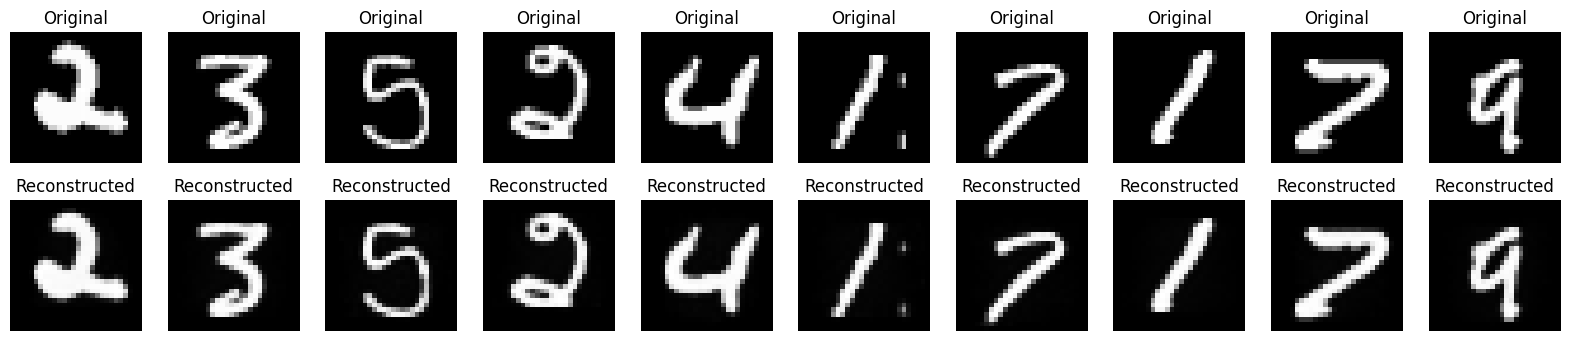

In [15]:
evaluate_model(model_passthrough, test_loader, mask_fraction=0.0, mask_type = "zero")

In [ ]:
# Model
model_bottleneck = AutoencoderBottleneck(input_dim=784, bottleneck_dim=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_bottleneck.parameters(), lr=0)

train_loop(model_bottleneck, train_loader, epochs=1)

Epoch 1: Loss = 0.0533
Epoch 2: Loss = 0.0253
Epoch 3: Loss = 0.0198
Epoch 4: Loss = 0.0174
Epoch 5: Loss = 0.0160


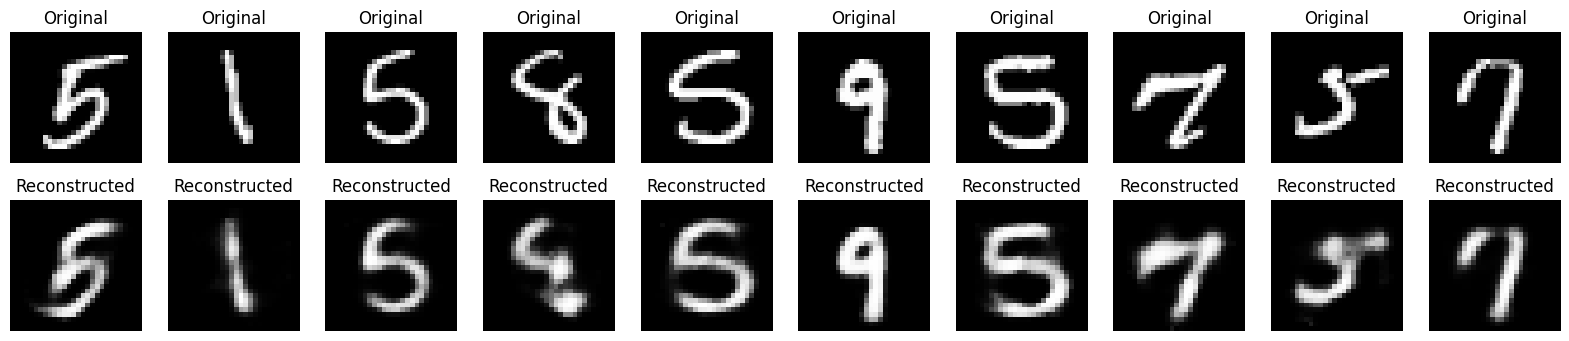

In [17]:
evaluate_model(model_bottleneck, test_loader, mask_fraction=0.0, mask_type = "zero")

In [ ]:
model_l2 = AutoencoderL2(input_dim=784).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_l2.parameters(), lr=1e-4)

train_loop(model_l2, train_loader, penalty_function=l2_penalty, lambda_penalty_param=0, epochs = 1)

Epoch 1: Loss = 0.0979
Epoch 2: Loss = 0.0561
Epoch 3: Loss = 0.0499
Epoch 4: Loss = 0.0483
Epoch 5: Loss = 0.0478
Epoch 6: Loss = 0.0477
Epoch 7: Loss = 0.0476
Epoch 8: Loss = 0.0476
Epoch 9: Loss = 0.0475
Epoch 10: Loss = 0.0475


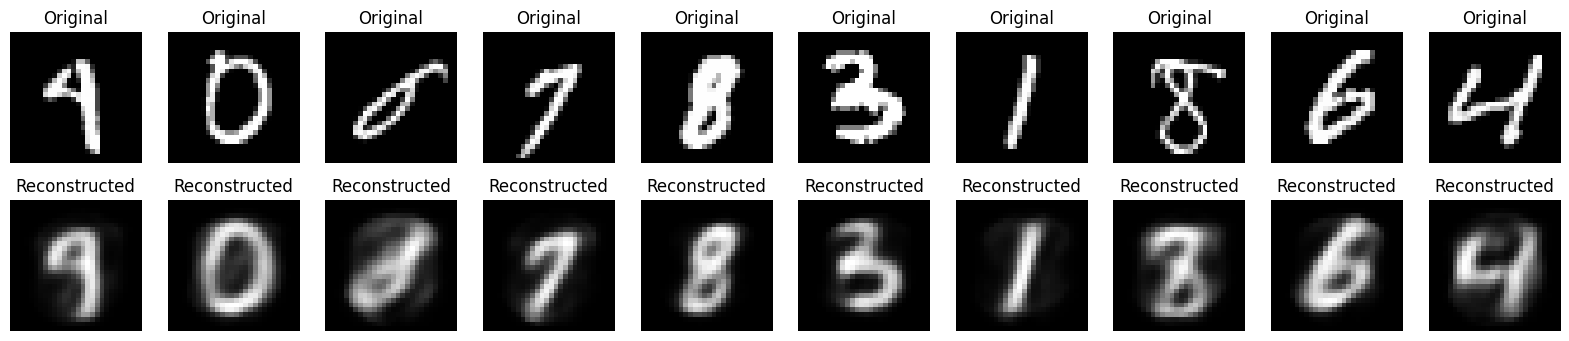

In [19]:
evaluate_model(model_l2, test_loader, mask_fraction=0.0, mask_type = 'zero')

In [ ]:
model_l1 = AutoencoderL1(input_dim=784).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_l1.parameters(), lr=0)

train_loop(model_l1, train_loader, penalty_function=l1_penalty, lambda_penalty_param=0, epochs = 0)#7e-6

Epoch 1: Loss = 0.0998
Epoch 2: Loss = 0.0541
Epoch 3: Loss = 0.0483
Epoch 4: Loss = 0.0452
Epoch 5: Loss = 0.0432
Epoch 6: Loss = 0.0417
Epoch 7: Loss = 0.0405
Epoch 8: Loss = 0.0395
Epoch 9: Loss = 0.0386
Epoch 10: Loss = 0.0376


In [22]:
def inspect_latent_representation(model, idx = 0):
  _, z = model(test_dataset[idx][0].to(device))
  return z

In [23]:
inspect_latent_representation(model_l1, idx = 10)

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.2893, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

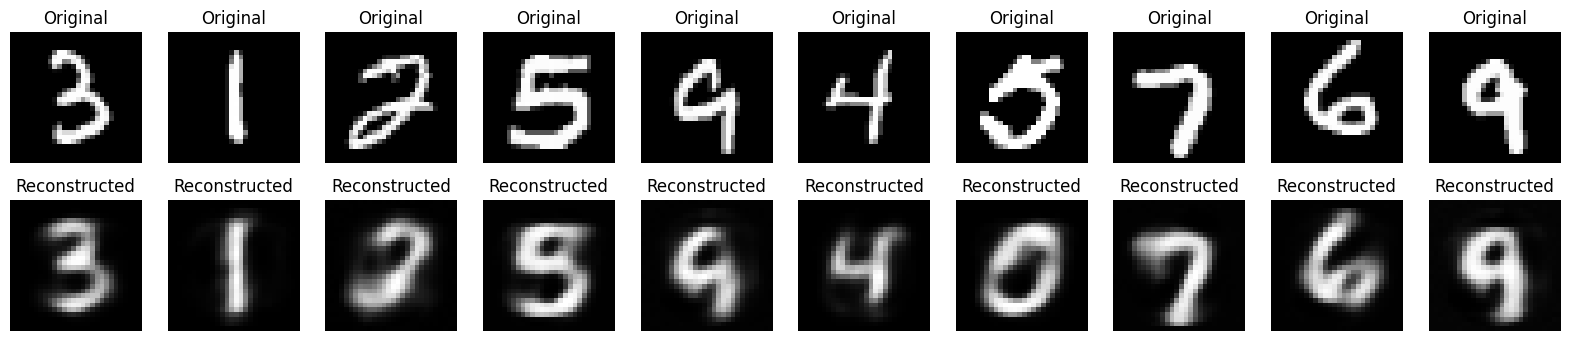

In [24]:
evaluate_model(model_l1, test_loader, mask_fraction=0.0, mask_type='zero')

In [ ]:
model_dropout = AutoencoderDropout(input_dim=784, dropout_prob=0).to(device)
criterion = nn.MSELoss()

optimizer = optim.Adam(model_dropout.parameters(), lr=0)

train_loop(model_dropout, train_loader, epochs = 1)

Epoch 1: Loss = 0.0358
Epoch 2: Loss = 0.0218
Epoch 3: Loss = 0.0201
Epoch 4: Loss = 0.0191
Epoch 5: Loss = 0.0185


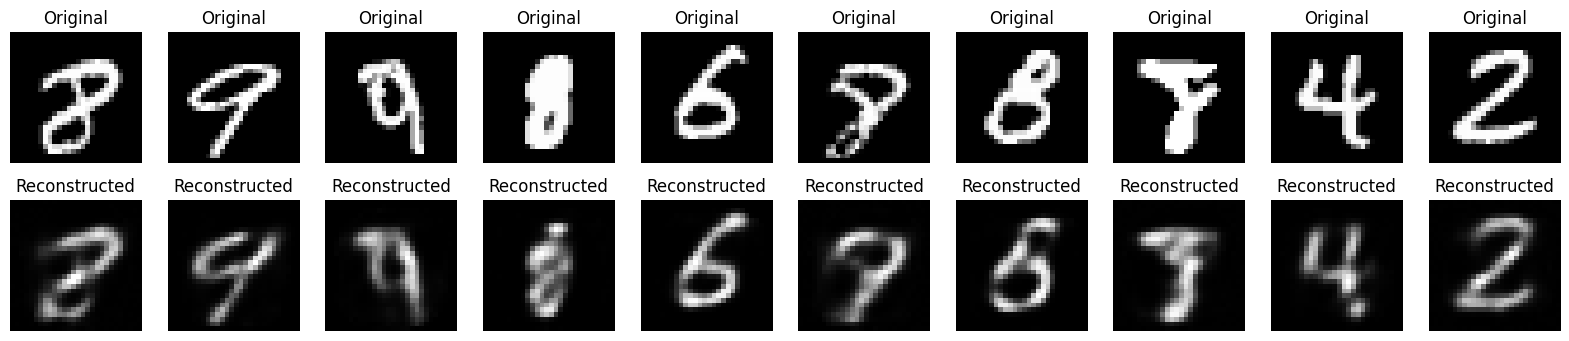

In [26]:
evaluate_model(model_dropout, test_loader, mask_fraction=0.5, mask_type='zero')

In [ ]:
def generate_latent_interpolation_gif(model, dataset, device,
                                       idx1=0, idx2=1,
                                       n_frames=30,
                                       output_filename='latent_interpolation.gif',
                                       fps=10):

    model.eval()

    with torch.no_grad():
        x1, _ = dataset[idx1]
        x2, _ = dataset[idx2]
        x1, x2 = x1.to(device), x2.to(device)

        _, z1 = model(x1)
        _, z2 = model(x2)

    alphas = np.linspace(0, 1, n_frames)
    frames = []

    for alpha in tqdm(alphas, desc="Generating frames"):
        z_alpha = z1 + alpha * (z2 - z1)
        with torch.no_grad():
            output = model.decoder(z_alpha)
        output_image = output.view(28, 28).cpu().numpy()

        fig, ax = plt.subplots(figsize=(2, 2))
        ax.imshow(output_image, cmap='gray')
        ax.axis('off')
        fig.tight_layout(pad=0)

        fig.canvas.draw()
        frame = np.array(fig.canvas.buffer_rgba())  # <- this line changed
        frames.append(frame)
        plt.close(fig)

    imageio.mimsave(output_filename, frames, fps=fps)
    print(f"GIF saved as {output_filename}")


In [ ]:
### Generate GIFs

n_idx = 10
for idx in range(n_idx):
  idx1 = idx
  idx2 = idx1 + 1
  for model in [model_bottleneck, model_l2, model_l1, model_dropout, model_passthrough]:
    generate_latent_interpolation_gif(model, test_dataset, device,idx1=idx1, idx2=idx2 ,output_filename= f"{model.__class__.__name__}-{idx}.gif")

Generating frames: 100%|██████████| 30/30 [00:00<00:00, 85.44it/s]


GIF saved as AutoencoderBottleneck-0.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 59.16it/s]


GIF saved as AutoencoderL2-0.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 90.29it/s]


GIF saved as AutoencoderL1-0.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 56.43it/s]


GIF saved as AutoencoderDropout-0.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 88.84it/s]


GIF saved as AutoencoderPassthrough-0.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 86.22it/s]


GIF saved as AutoencoderBottleneck-1.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 48.17it/s]


GIF saved as AutoencoderL2-1.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 60.44it/s]


GIF saved as AutoencoderL1-1.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 61.67it/s]


GIF saved as AutoencoderDropout-1.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 34.42it/s]


GIF saved as AutoencoderPassthrough-1.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 88.73it/s]


GIF saved as AutoencoderBottleneck-2.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 87.78it/s]


GIF saved as AutoencoderL2-2.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 88.11it/s]


GIF saved as AutoencoderL1-2.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 41.85it/s]


GIF saved as AutoencoderDropout-2.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 86.90it/s]


GIF saved as AutoencoderPassthrough-2.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 85.98it/s]


GIF saved as AutoencoderBottleneck-3.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 89.58it/s]


GIF saved as AutoencoderL2-3.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 86.50it/s]


GIF saved as AutoencoderL1-3.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 35.95it/s]


GIF saved as AutoencoderDropout-3.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 84.61it/s]


GIF saved as AutoencoderPassthrough-3.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 85.61it/s]


GIF saved as AutoencoderBottleneck-4.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 85.17it/s]


GIF saved as AutoencoderL2-4.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 86.91it/s]


GIF saved as AutoencoderL1-4.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 88.66it/s]


GIF saved as AutoencoderDropout-4.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 83.02it/s]


GIF saved as AutoencoderPassthrough-4.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 32.81it/s]


GIF saved as AutoencoderBottleneck-5.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 88.14it/s]


GIF saved as AutoencoderL2-5.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 87.99it/s]


GIF saved as AutoencoderL1-5.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 88.83it/s]


GIF saved as AutoencoderDropout-5.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 58.62it/s]


GIF saved as AutoencoderPassthrough-5.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 59.08it/s]


GIF saved as AutoencoderBottleneck-6.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 58.27it/s]


GIF saved as AutoencoderL2-6.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 53.36it/s]


GIF saved as AutoencoderL1-6.gif


Generating frames: 100%|██████████| 30/30 [00:01<00:00, 27.88it/s]


GIF saved as AutoencoderDropout-6.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 85.46it/s]


GIF saved as AutoencoderPassthrough-6.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 84.35it/s]


GIF saved as AutoencoderBottleneck-7.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 81.28it/s]


GIF saved as AutoencoderL2-7.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 78.76it/s]


GIF saved as AutoencoderL1-7.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 80.00it/s]


GIF saved as AutoencoderDropout-7.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 86.43it/s]


GIF saved as AutoencoderPassthrough-7.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 82.91it/s]


GIF saved as AutoencoderBottleneck-8.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 78.72it/s]


GIF saved as AutoencoderL2-8.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 84.05it/s]


GIF saved as AutoencoderL1-8.gif


Generating frames: 100%|██████████| 30/30 [00:01<00:00, 24.40it/s]


GIF saved as AutoencoderDropout-8.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 88.38it/s]


GIF saved as AutoencoderPassthrough-8.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 84.99it/s]


GIF saved as AutoencoderBottleneck-9.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 90.90it/s]


GIF saved as AutoencoderL2-9.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 88.16it/s]


GIF saved as AutoencoderL1-9.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 85.89it/s]


GIF saved as AutoencoderDropout-9.gif


Generating frames: 100%|██████████| 30/30 [00:00<00:00, 88.38it/s]


GIF saved as AutoencoderPassthrough-9.gif


In [29]:
print("Done!")

Done!
